In [10]:
import os
import re
from dotenv import load_dotenv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [5]:
def is_text_contains_html(text: str):
    html_tags_regex_pattern = r"""<(“[^”]*”|'[^’]*’|[^'”>]*)>"""
    return re.search(html_tags_regex_pattern, text) != None


def is_text_contains_too_many_ucases(text: str, threshold=500):
    uppercase_regex_pattern = r"""[A-Z]"""
    return (
        len(
            [
                mtch
                for row in re.findall(uppercase_regex_pattern, text)
                for mtch in row
                if mtch
            ]
        )
        > threshold
    )


def count_text_urls(text: str):
    url_regex_ptrn = r"((http|ftp|https):\/\/)?([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?"
    return len(
        [mtch for row in re.findall(url_regex_ptrn, text) for mtch in row if mtch]
    )


def count_text_emails(text: str):
    email_regex_pattern = r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
    return len(re.findall(email_regex_pattern, text))


def refine_email_content(email_text: str):
    first_double_new_line_char_idx = email_text.split("\n").index("")
    prev_line_text = email_text.split("\n")[first_double_new_line_char_idx - 1]

    place_after_header = email_text.find(prev_line_text) + len(prev_line_text)

    return email_text[place_after_header:].strip().strip('\n')


def stem_words(words):
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))

    return stemmed_words


def calc_text_indicator_words_score(text: str):
    indicator_words = {
        "milf": {"severity": 0.9},
        "adult": {"severity": 0.8},
        "penis": {"severity": 0.9},
        "sex": {"severity": 0.8},
        "click": {"severity": 0.4},
        "here": {"severity": 0.2},
        "$": {"severity": 0.5},
        "offer": {"severity": 0.1},
        "give": {"severity": 0.1},
        "away": {"severity": 0.2},
        "free": {"severity": 0.5},
        "forever": {"severity": 0.1},
        "money": {"severity": 0.3},
        "cash": {"severity": 0.6},
        "profit": {"severity": 0.5},
        "market": {"severity": 0.4},
        "fat": {"severity": 0.5},
        "slim": {"severity": 0.5},
    }

    indicator_words_count = {}

    raw_words = word_tokenize(text.lower())
    stemmed_words = stem_words(raw_words)

    for word in stemmed_words:
        if word in indicator_words:
            if word not in indicator_words_count:
                indicator_words_count[word] = 0

            indicator_words_count[word] += 1

    score = 0
    for word in indicator_words_count:
        score += indicator_words_count[word] * indicator_words[word]["severity"]

    return score


def load_emails(main_dir_path, dirs_is_spam, limit=None):
    emails = []
    for email_dir_name in os.listdir(main_dir_path):
        emails_dir_path = os.path.join(main_dir_path, email_dir_name)

        if limit:
            email_files_to_consider = os.listdir(emails_dir_path)[:limit]
        else:
            email_files_to_consider = os.listdir(emails_dir_path)

        for email_file_name in email_files_to_consider:
            email_full_path = os.path.join(emails_dir_path, email_file_name)

            try:
                with open(email_full_path, "r", encoding="windows-1252") as f:
                    raw_content = f.read()
            except UnicodeDecodeError:
                continue

            email_id = email_file_name.split(".")[-1]
            main_content = refine_email_content(raw_content)
            emails.append(
                {
                    "email_id": email_id,
                    "contains_html": is_text_contains_html(main_content),
                    "contains_many_ucase": is_text_contains_too_many_ucases(
                        main_content
                    ),
                    "indicator_words_score": calc_text_indicator_words_score(
                        main_content
                    ),
                    "email_counts": count_text_emails(main_content),
                    "url_counts": count_text_urls(main_content),
                    "is_spam": dirs_is_spam[email_dir_name],
                }
            )

        emails_df = pd.DataFrame(emails)

    return emails_df


In [11]:
load_dotenv()

emails_df = load_emails(
    os.getenv("DATASET_PATH"),
    {"spam": True, "hard_ham": False, "easy_ham": False},
)
emails_df.set_index("email_id", inplace=True)


/run/media/neotod/internal_hdd/compsci/datasets/email_spam_clf


In [4]:
emails_df

,contains_html,contains_many_ucase,indicator_words_score,email_counts,url_counts,is_spam
email_id,,,,,,
ea7e79d3153e7469e7a9c3e0af6a357e,True,False,1.5,3,11,False
b3120c4bcbf3101e661161ee7efcb8bf,False,False,0.5,1,9,False
acfc5ad94bbd27118a0d8685d18c89dd,False,False,0.7,1,9,False
e8d5727378ddde5c3be181df593f1712,False,False,0.0,1,9,False
8c3b9e9c0f3f183ddaf7592a11b99957,False,False,0.3,1,8,False
...,...,...,...,...,...,...
8c39bfed2079f865e9dfb75f4416a468,True,True,1.0,6,25,True
886f4a22362f4d3528c3e675878f17f7,False,False,1.5,1,8,True
9790e1c57fcbf7885b7cd1719fb4681b,False,False,1.1,1,24,True


<AxesSubplot:xlabel='is_spam', ylabel='contains_html'>

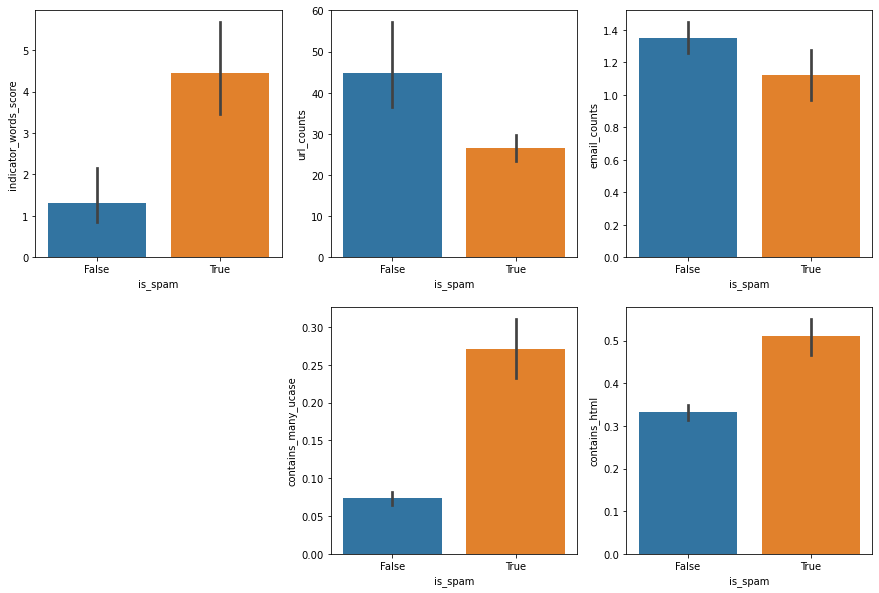

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.barplot(x="is_spam", y="indicator_words_score", data=emails_df)

plt.subplot(2, 3, 2)
sns.barplot(x="is_spam", y="url_counts", data=emails_df)

plt.subplot(2, 3, 3)
sns.barplot(x="is_spam", y="email_counts", data=emails_df)

plt.subplot(2, 3, 5)
sns.barplot(x="is_spam", y="contains_many_ucase", data=emails_df)

plt.subplot(2, 3, 6)
sns.barplot(x="is_spam", y="contains_html", data=emails_df)



#### Data prepration

In [6]:
X = emails_df.iloc[:, :len(emails_df.columns)-1]
y = emails_df.iloc[:, -1]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

In [8]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
svc_clf.score(X_train, y_train)


0.8501517450682853

In [9]:
svc_clf.score(X_test, y_test)


0.8560606060606061

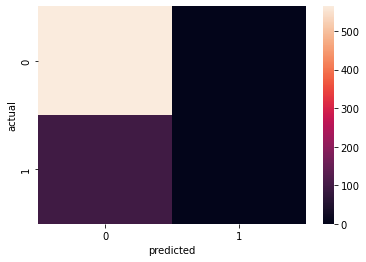

In [10]:
svc_conf_mtx = confusion_matrix(y_test, svc_clf.predict(X_test))
ax = sns.heatmap(svc_conf_mtx)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
plt.show()

### RandomForest

In [11]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_clf.score(X_train, y_train)

0.9795144157814871

In [12]:
rf_clf.score(X_test, y_test)

0.9227272727272727

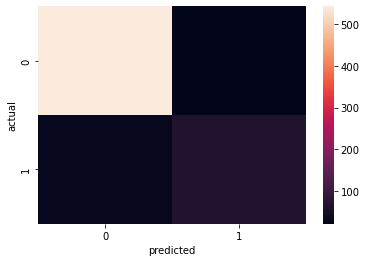

In [13]:
rf_conf_mtx = confusion_matrix(y_test, rf_clf.predict(X_test))
ax = sns.heatmap(rf_conf_mtx)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
plt.show()

### Logistic Regression

In [14]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_train, y_train)

0.8767071320182094

In [15]:
lr_clf.score(X_test, y_test)

0.8666666666666667

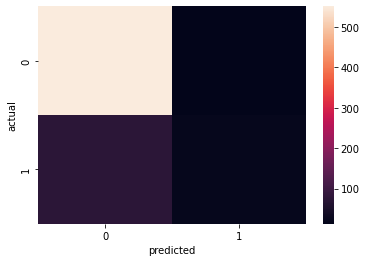

In [16]:
lr_conf_mtx = confusion_matrix(y_test, lr_clf.predict(X_test))
ax = sns.heatmap(lr_conf_mtx)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
plt.show()

In [17]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train)

0.9795144157814871

In [18]:
dt_clf.score(X_test, y_test)

0.9196969696969697

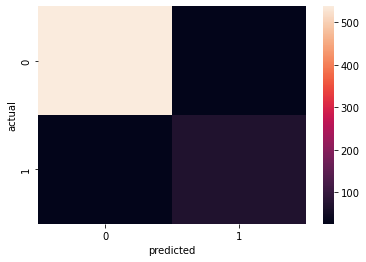

In [19]:
dt_conf_mtx = confusion_matrix(y_test, dt_clf.predict(X_test))
ax = sns.heatmap(dt_conf_mtx)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
plt.show()

### Comparing classifiers using K-Fold cross validation score

In [20]:
lr_clf2 = LogisticRegression()
lr_clf2_scores = cross_val_score(lr_clf2, X, y, scoring='roc_auc', cv=200)

rf_clf2 = RandomForestClassifier()
rf_clf2_scores = cross_val_score(rf_clf2, X, y, scoring='roc_auc', cv=200)

svc_clf2 = SVC()
svc_clf2_scores = cross_val_score(svc_clf2, X, y, scoring='roc_auc', cv=200)

dt_clf2 = DecisionTreeClassifier()
dt_clf2_scores = cross_val_score(dt_clf2, X, y, scoring='roc_auc', cv=200)

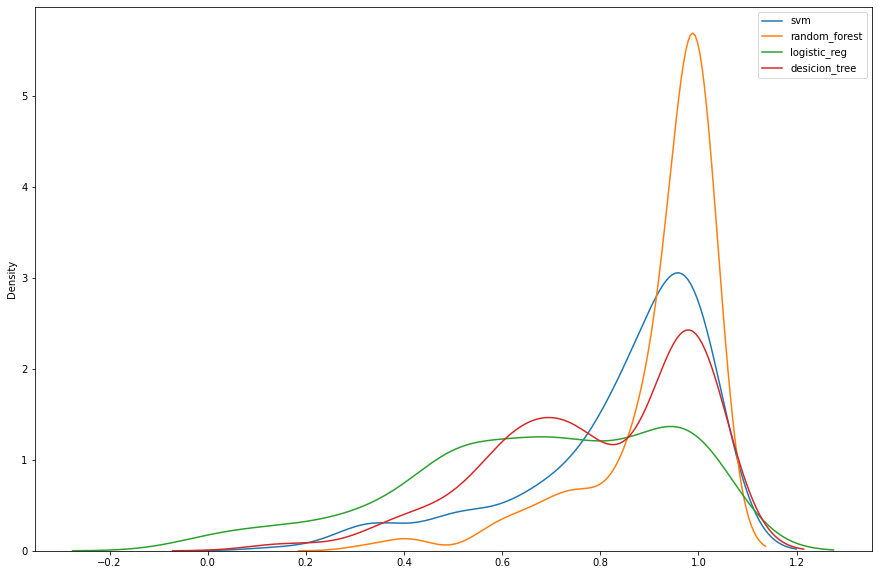

In [21]:
plt.figure(figsize=(15, 10))
sns.kdeplot(svc_clf2_scores)
sns.kdeplot(rf_clf2_scores)
sns.kdeplot(lr_clf2_scores)
sns.kdeplot(dt_clf2_scores)
plt.legend(['svm', 'random_forest', 'logistic_reg', 'desicion_tree'])
plt.show()